In [1]:
# Internship Task-4: Recommendation System using Matrix Factorization

In [2]:
# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 2: Create Sample Dataset (Movie Ratings)
ratings_dict = {
    "user_id": [0, 0, 0, 1, 1, 2, 2, 2, 3, 3],
    "movie_id": [0, 1, 2, 1, 2, 0, 2, 3, 0, 3],
    "rating": [5, 3, 2, 4, 3, 4, 5, 3, 2, 4]
}
df = pd.DataFrame(ratings_dict)
print("Ratings Data:")
print(df)

Ratings Data:
   user_id  movie_id  rating
0        0         0       5
1        0         1       3
2        0         2       2
3        1         1       4
4        1         2       3
5        2         0       4
6        2         2       5
7        2         3       3
8        3         0       2
9        3         3       4


In [4]:
# Step 3: Matrix Factorization using SVD
class MatrixFactorization:
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        self.P = np.random.normal(
            scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(
            scale=1./self.K, size=(self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        self.training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            self.training_process.append((i, mse))
            print(f"Iteration: {i+1} ; error = {mse:.4f}")
        return self.full_matrix()

    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error / len(xs))

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            self.P[i, :] += self.alpha * \
                (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * \
                (e * self.P[i, :] - self.beta * self.Q[j, :])

    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + \
            self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [7]:
# Step 4: Create Rating Matrix
R_df = df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = R_df.values

In [8]:
# Step 5: Train Matrix Factorization Model
mf = MatrixFactorization(R, K=2, alpha=0.01, beta=0.01, iterations=20)
predicted_matrix = mf.train()

Iteration: 1 ; error = 1.0898
Iteration: 2 ; error = 1.0797
Iteration: 3 ; error = 1.0701
Iteration: 4 ; error = 1.0613
Iteration: 5 ; error = 1.0530
Iteration: 6 ; error = 1.0453
Iteration: 7 ; error = 1.0379
Iteration: 8 ; error = 1.0310
Iteration: 9 ; error = 1.0243
Iteration: 10 ; error = 1.0181
Iteration: 11 ; error = 1.0122
Iteration: 12 ; error = 1.0066
Iteration: 13 ; error = 1.0012
Iteration: 14 ; error = 0.9961
Iteration: 15 ; error = 0.9913
Iteration: 16 ; error = 0.9866
Iteration: 17 ; error = 0.9822
Iteration: 18 ; error = 0.9779
Iteration: 19 ; error = 0.9737
Iteration: 20 ; error = 0.9697


In [9]:
# Step 6: Compare Predictions
pred_df = pd.DataFrame(
    predicted_matrix, columns=R_df.columns, index=R_df.index)
print("\nPredicted Ratings Matrix:")
print(pred_df.round(2))


Predicted Ratings Matrix:
movie_id     0     1     2     3
user_id                         
0         3.47  3.31  3.36  3.63
1         3.68  3.63  3.49  3.91
2         3.84  3.70  3.58  3.75
3         3.23  2.98  3.14  3.22


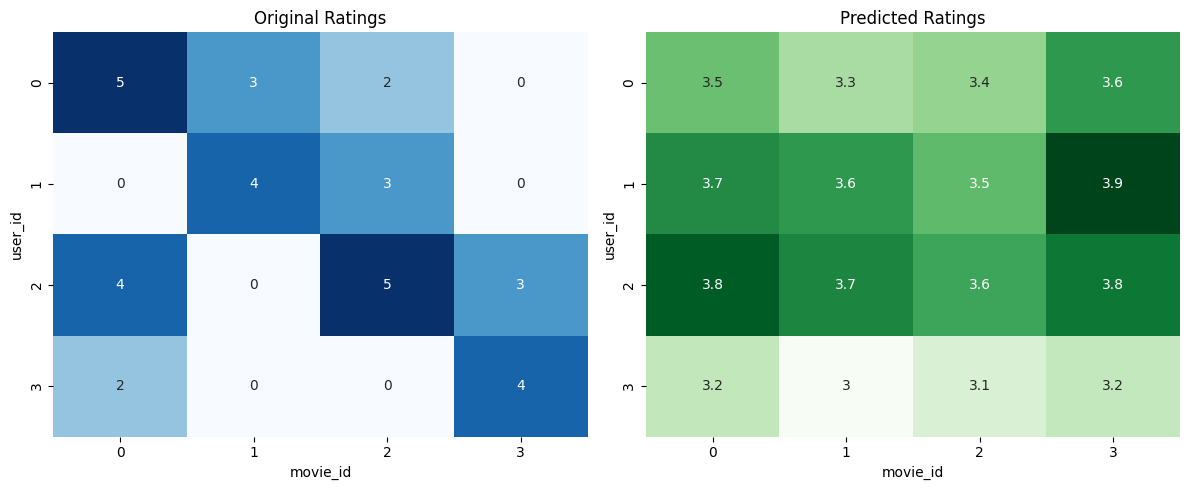

In [10]:
# Step 7: Visualize Original vs Predicted Ratings
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(R_df, annot=True, cmap='Blues', cbar=False)
plt.title("Original Ratings")

plt.subplot(1, 2, 2)
sns.heatmap(pred_df.round(2), annot=True, cmap='Greens', cbar=False)
plt.title("Predicted Ratings")

plt.tight_layout()
plt.show()